In [1]:
# TODO
# draw thresholds for disease loci
# CODIS look at the ones that are way off

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
%pylab inline
import os
import pandas as pd

# Set up population list
popcolors = {}
popcolors["AFR"] = "orange"
popcolors["AMR"] = "red"
popcolors["EAS"] = "green"
popcolors["EUR"] = "blue"
popcolors["SAS"] = "purple"

# Set up locus list
locids = {}
locids["chr5:146878728"] = "1_PPP2R2B"
locids["chr19:45770205"] = "2_DMPK"
locids["chr4:3074877"] = "3_HTT"

locids["chr5:123775551"] = "1_D5S818"
locids["chr2:1489650"] = "2_TPOX"
locids["chr5:150076321"] = "3_CSF1PO"
locids["chr7:84160223"] = "4_D7S820"
locids["chr8:124894865"] = "5_D8S1179"
locids["chr11:2171085"] = "6_TH01"
locids["chr13:82148025"] = "7_D13S317"
locids["chr15:96831012"] = "8_PentaE"
locids["chr16:86352702"] = "9_D16S539"
locids["chr18:63281667"] = "10_D18S51"
locids["chr21:43636205"] = "11_PentaD"

codis_list = ["1_D5S818","2_TPOX","3_CSF1PO","4_D7S820","5_D8S1179", \
              "6_TH01","7_D13S317","8_PentaE","9_D16S539","10_D18S51","11_PentaD"]
disease_list = ["1_PPP2R2B","2_DMPK", "3_HTT"]

# Load known/observed for CODIS/disease
def LoadAfreq(fname):
    data = pd.read_csv(fname, sep="\t")
    data["id"] = data.apply(lambda x: locids.get("%s:%s"%(x["chrom"], x["start"]), "NA"), 1)
    data = data[data["id"] != "NA"]
    data["sort_id"] = data.apply(lambda x : int(x["id"].split("_")[0]), 1)
    data = data.sort_values(by = "sort_id")
    return data

codis_obs_freqs = LoadAfreq("called_freqs_codis.tab")
disease_obs_freqs = LoadAfreq("called_freqs_disease.tab")

disease_freqs = pd.read_csv("disease_afreqs.txt", sep="\t")
known_freqs = pd.read_csv("known_afreqs.txt", delim_whitespace=True)

Populating the interactive namespace from numpy and matplotlib


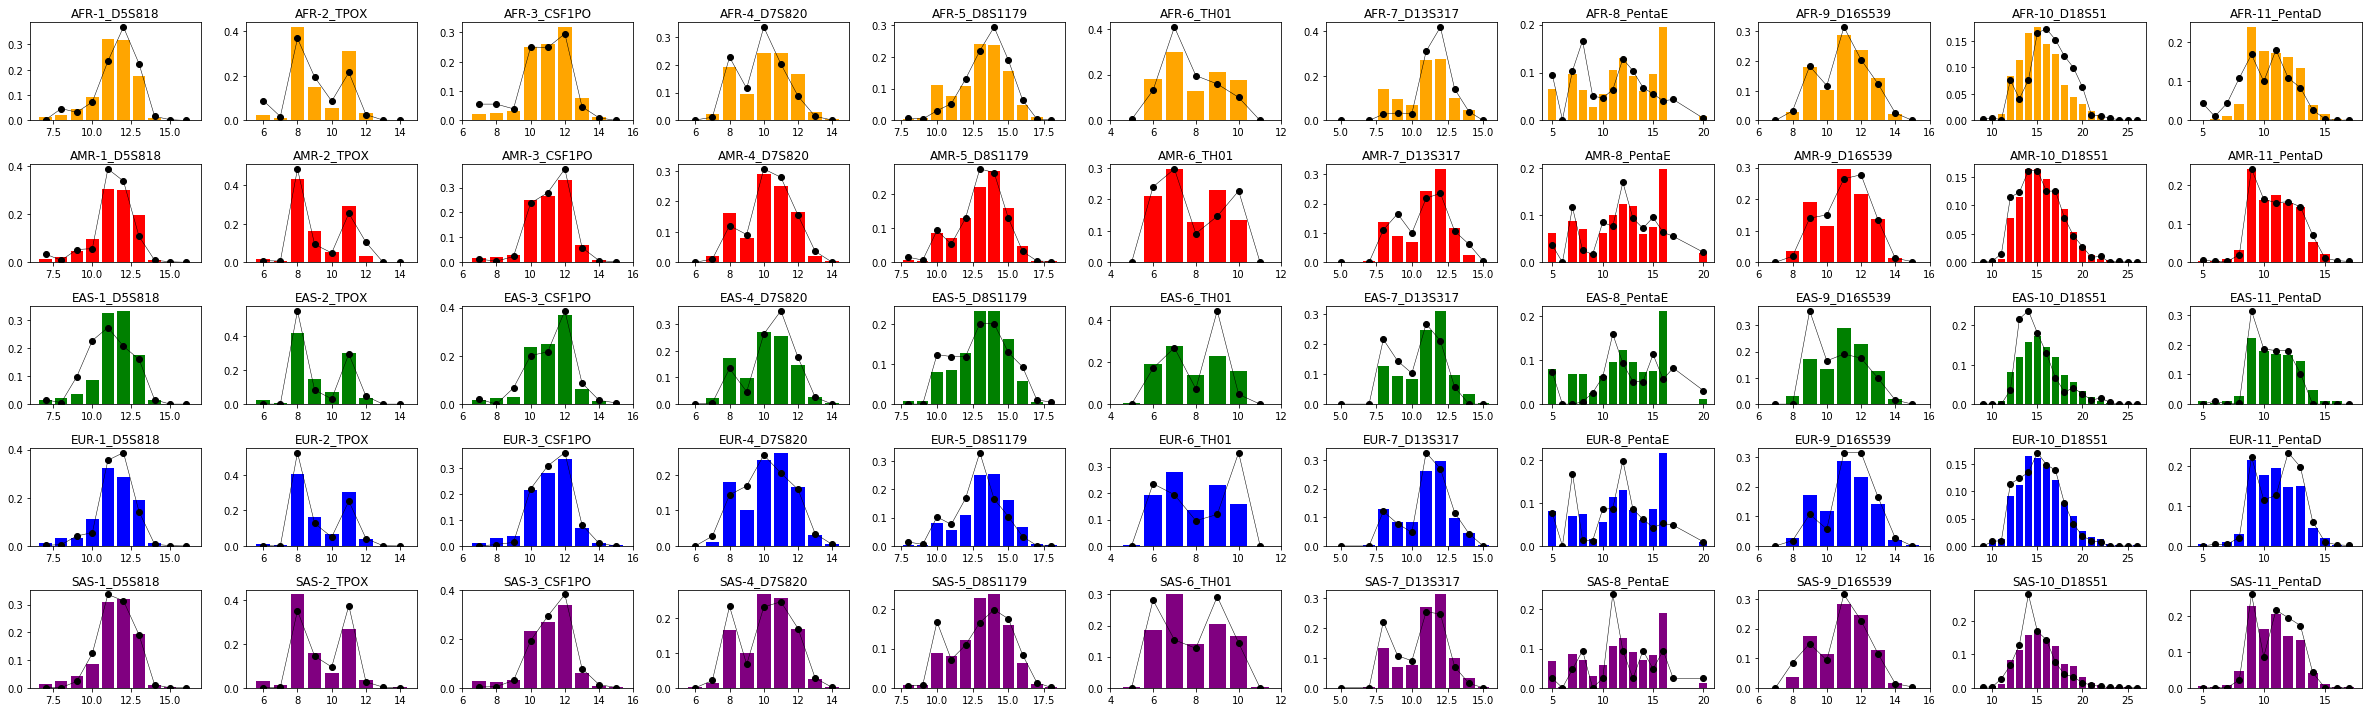

In [13]:
def PlotFreqs(called_freqs, known_freqs, popcolors, locus_list, thresholds=None, figname=None):
    superpops = list(popcolors.keys())
    num_pops = len(superpops) # =numrows
    num_loci = called_freqs.shape[0] # =numcols

    fig, axis_array = plt.subplots(len(superpops), num_loci, figsize=(num_loci*3, len(superpops)*2))
    plotnum = 0    

    for i in range(called_freqs.shape[0]):
        chrom = called_freqs["chrom"].values[i]
        pos = called_freqs["start"].values[i]
        locus_id = called_freqs["id"].values[i]
        if (locus_id not in locus_list):
            continue

        # Load called freqs
        alleles = set()
        popcounts = {}
        for sp in superpops:
            spcts = {}
            ctstring = called_freqs["freq_%s"%sp].values[i]

            for allele in ctstring.split(","):
                al, fq = allele.split(":")
                al = int(float(al)); fq = float(fq)
                if locus_id == "1_D5S818": al = al - 1
                spcts[al] = spcts.get(al, 0) + fq

            for a in spcts.keys(): alleles.add(a)
            popcounts[sp] = spcts
        if thresholds is not None and locus_id in thresholds.keys(): alleles.add(thresholds[locus_id])
        alleles = sorted(list(alleles))
        # Load known freqs
        k = known_freqs[(known_freqs["chrom"]==chrom) & (known_freqs["pos"]==pos)]
        kcounts = {}
        for sp in superpops:
            spcts = {}
            cstring = k["freq_%s"%sp].values[0]
            if str(cstring) == "nan": continue
            for allele in cstring.split(","):
                al, fq = allele.split(":")
                al = np.ceil(float(al)); fq = float(fq)
                spcts[al] = spcts.get(al, 0) + fq
            kcounts[sp] = spcts 
            
        for j in range(len(superpops)):
            if num_loci == 1:
                ax = axis_array[j]
            else:
                ax = axis_array[j, i]
            ax.bar(alleles, [popcounts[superpops[j]].get(a, 0) for a in alleles], color=popcolors[superpops[j]])
        
            # Plot known
            if superpops[j] in kcounts.keys():
                ax.plot(alleles, [kcounts[superpops[j]].get(a, 0) for a in alleles], color="black",
                    marker="o", linewidth=0.5)
 
            # Plot threshold
            if thresholds is not None and locus_id in thresholds.keys():
                ax.axvline(x=thresholds[locus_id], linewidth=0.5, linestyle="dashed", color="black")
            ax.set_xlim(left=min(alleles)-1, right=max(alleles)+1)
            ax.set_title("%s-%s"%(superpops[j], locus_id))
            plotnum += 1
    fig.tight_layout() 
    if figname is not None: plt.savefig(figname, dpi=1200)
        
PlotFreqs(codis_obs_freqs, known_freqs, popcolors, codis_list, thresholds=None, figname="pdfs/1000G-CODIS-Afreq.pdf")

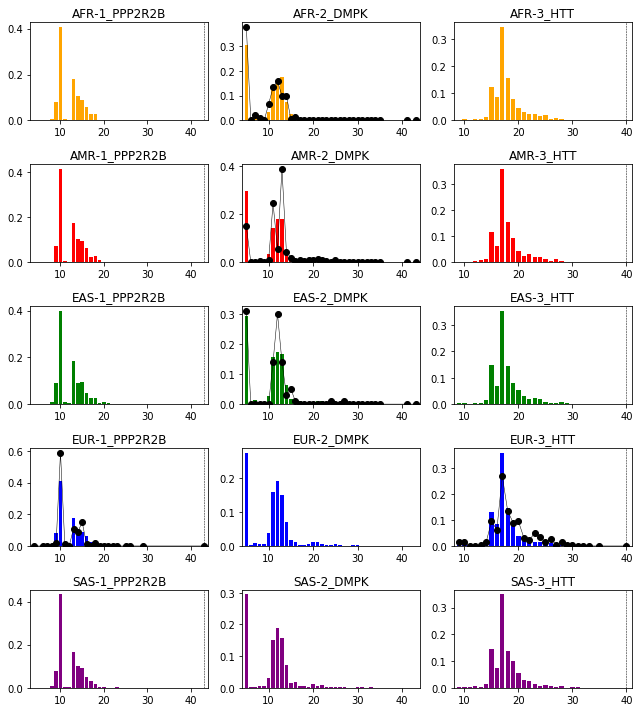

In [8]:
thresholds = {
    "3_HTT": 40,
    "1_PPP2R2B": 43,
}
PlotFreqs(disease_obs_freqs, disease_freqs, popcolors, disease_list, thresholds=thresholds, figname="pdfs/1000G-Disease-Afreq.pdf")

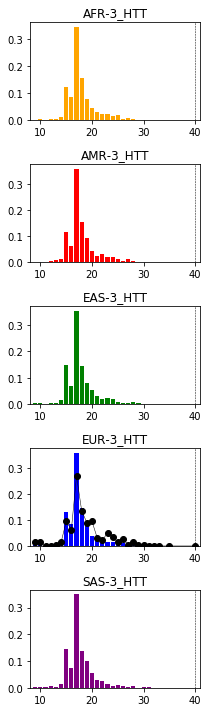

In [14]:
#### HTT

thresholds = {
    "3_HTT": 40,
}
HTT_obs_freqs = disease_obs_freqs[disease_obs_freqs['chrom'] == "chr4"]
HTT_freqs = disease_freqs[disease_freqs['chrom'] == 'chr4']
PlotFreqs(HTT_obs_freqs, HTT_freqs, popcolors, disease_list, thresholds=thresholds, figname="pdfs/1000G-HTT-Afreq.pdf")


